# Feed Forward Neural Network
**Using Neural Networks to predict essay grades using vectorized essays** 

Neural networks were used to predict the grade of the essay by 90% of the data
training and 10% of the data testing. Three layers of the neural network were created
with an input layer, two layers on neurons and with an output node. 

Let's look at the architecture, initialization and cost.

In [1]:
%%capture
from essay2vec import *;

**Weight and Bias Variable**

This neural network employed a linear summation of biases (b) and a product of weights (W) and
data of that layer (x) according to an equation below:

Y = W*x + b

The weights were initiated as the shape of [previous layer, next layer], assigned to a
value of 0.1. These weights were revised while the neural network was trained. The
weights were optimized with the increasing epochs number. As a result, the accuracy of
the training and response variables testing could be monitored. The biases were
initiated as the shape of [next layer]. Similarly, the biases were optimized with the
increasing epochs number during the training.

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

**Neural Network Architecture**

A feed-forward neural network architecture was employed. The number of input
nodes was the number of training essay features (300). These were fed into a 500 nodes
layer, the input of these nodes was activated by a ReLU function, that was obtained
from the matrix operation of weights, input nodes, and biases. Then the first layer
output was fed into 750 nodes layer, the input was activated by a ReLU function
similarly. Finally, the output node created a regression result.
The employed loss function in optimization was the Mean Square Error of the
predicted score versus the real score. Adam-Optimizer was used to find the best-
optimized loss function that trained the model.

In [3]:
batch_size = 300
hidden_nodes_1 = 500
hidden_nodes_2 = 750
size = testDataVecs.shape[1]

graph = tf.Graph()
with graph.as_default():

    # Input data.
    with tf.name_scope("Input"):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
    tf_test_dataset = tf.constant(testDataVecs)
      
    layer1_weights = weight_variable([size, hidden_nodes_1])
    layer1_biases = bias_variable([hidden_nodes_1]) 
    
    layer2_weights = weight_variable([hidden_nodes_1, hidden_nodes_2])
    layer2_biases = bias_variable([hidden_nodes_2])
    
    layer3_weights = weight_variable([hidden_nodes_2, 1])
    layer3_biases = bias_variable([1])
    
    def model(data):
        with tf.name_scope("Layer_1"):
            layer1 = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
        
        with tf.name_scope("Layer_2"):
            
            layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weights) + layer2_biases)

        with tf.name_scope("Layer_3"):
            layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weights) + layer3_biases)
        return layer3
    
    # Training computation.
    yhat = model(tf_train_dataset)
    
    with tf.name_scope("Loss"):
        loss = tf.reduce_mean(tf.square(yhat - tf_train_labels))
    
    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.001
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    
    with tf.name_scope("Train"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    tf.summary.scalar("loss", loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = yhat
    test_prediction = model(tf_test_dataset)

**Training and Testing Prediction**

The neural network was then trained on essay batches. The error minimization
was used to optimize the learning rate by adjusting the weights and biases of each layer.
The accuracy of each epoch was calculated with the spearman correlation at each epoch
and lastly, the spearman score for the test set was calculated.

In [4]:
test_preds = pd.DataFrame()
# Re-define the function to include the keep probability
l_array = []
start = timeit.timeit()
num_epochs = 3001
def run_session(num_epochs, name):
    with tf.Session(graph=graph) as session:
        writer = tf.summary.FileWriter("logs/", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = trainDataVecs[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size)]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            l_array.append(l)
            if (epoch % 500 == 0):
                print("Minibatch Loss at Epoch {}: {:.3f}".format(epoch, l))
                rho, pval = (spearmanr(predictions, batch_labels))
                print("Minibatch Spearman Score: {:.4f}".format(rho))
        final_rho, pval = spearmanr(test_prediction.eval(), y_test)
        print("Test Spearman Score: {:.4f}".format(final_rho))
        test_preds[name] = test_prediction.eval().ravel()
        filesave = np.zeros((len(y_test), 2))
        to_use = test_prediction.eval()
        
        for ii in range(len(y_test)):           
            filesave[ii, 0] = y_test[ii]
            filesave[ii, 1] = to_use[ii]
        
        np.savetxt('savetest.txt', filesave, delimiter=",", fmt="%d") 
        
run_session(num_epochs, "Deep_NN")
total = timeit.timeit() - start

Initialized
Minibatch Loss at Epoch 0: 4.203
Minibatch Spearman Score: 0.1206
Minibatch Loss at Epoch 500: 0.415
Minibatch Spearman Score: 0.3273
Minibatch Loss at Epoch 1000: 0.355
Minibatch Spearman Score: 0.4419
Minibatch Loss at Epoch 1500: 0.304
Minibatch Spearman Score: 0.4947
Minibatch Loss at Epoch 2000: 0.283
Minibatch Spearman Score: 0.5844
Minibatch Loss at Epoch 2500: 0.293
Minibatch Spearman Score: 0.5514
Minibatch Loss at Epoch 3000: 0.305
Minibatch Spearman Score: 0.5550
Test Spearman Score: 0.4837


**Loss vs Epoch**

As expected, the loss was minimized while the number of epochs was increased
in Figure 1. This implied that the MSE loss function was lowered during the training
and the optimal answer was obtained.

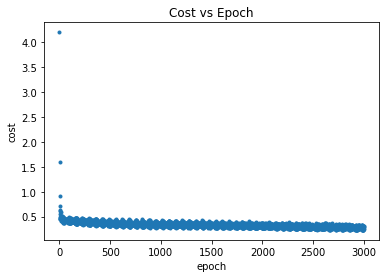

In [5]:
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Cost vs Epoch")
plt.show()

**Results**

Having tested the Neural Network on 10% of the data and trained on 90% of the data, the Spearman score was 0.4837, with quite low computation time. This means the accuracy of the model is moderate.  More essays were needed, or the topic of the essay should be very specific for more accuracy.  